# Business Problem

Como um Consultor de Ciência de Dados para criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

Entregáveis da consultoria:

- Modelo em produção com API.
- Relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu.

  No seu relatório deve conter as respostas para as seguintes perguntas:

 -   Qual a Precisão e Acurácia do modelo?
 -   Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
 -   Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
 -   Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
 -   Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

Data source: [Link](https://www.kaggle.com/ntnu-testimon/paysim1)

**Index:**

 - 1.0 Problema de Negócio
 - 1.1 Importações de bibliotecas
 - 2.0 Coleta de Dados
 - 3.0 Descrição dos Dados
 - 4.0 Limpeza de dados
 - 5.0 Feature Engineering
 - 6.0 EDA
 - 7.0 Feature Selection
 - 8.0 Data Preparation - Pipelines
 - 9.0 Modelagem Machine Learning / Avaliação dos Modelos
 - 10.0 Interpretação do Modelo
 - 11.0 API

**Estrátegia:**

2.0 Coleta de Dados:
- Coletar os dados utilizando pd.read_csv().

3.0 Descrição dos Dados:

- Descrever as seguintes infos por feature: percentual de missing, valores únicos, percentual de valores únicos, tipos de dados, skew, kurtosis.                                             
- Investigar isFraud vs isFlaggedFraud para determinar qual é a variável target.
- Descrever a variável 'type' com relação ao target.
- Descrever outras variáveis
 
4.0 Limpeza de dados:

- Investigar e eliminar os outliers
- Excluir os 'types' diferentes de 'TRANSFER'e 'CASH_OUT'
- Avaliar o tamanho do dataset e decidir sobre utilizar alguma estratégia de sampling.
 
5.0 Feature Engineering

- Criar a variável type_dest a partir da primeira letra da variável nameDest. C representa 'Customer' e M representa 'Merchant'.

- Criar a variável erro_transaction, espera-se que 'amount' - (oldbalanceOrg - newbalanceOrig) seja igual a zero talvez erros maiores podem levar o modelo entender o evento de Fraude. 

- Criar variável por iteração 'amount' / 'step' = 'amount_step', o relacionamento do valor da transação por unidade de tempo pode nos ajudar a modelar o evento.

- Criar variáveis a partir do WeightOfEvidenceEncoder. WOE é uma medida do quão bem a observação suporta ou mitiga a hipostese - H0.
  - A partir dest_type criar woe_encoded_dest_type
  - A partir type criar woe_encoded_type
  
- Criar variáveis a partir do grupamento de 'type', calculando-se a média e o desvio padrão das variáveis 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'. Objetivo aqui é gerar sinais que ajude o modelo a separar melhor o evento de fraude das transações comuns.

- Criar variáveis aplicando transformação logaritmica nas varáveis 'amount','step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'. A transformação logartmica foi escolhida por ser aproriada para lidar com skew das variáveis citadas anteriormente.

- Realizar o binning, utilizando a estrátegia de k-means, com o objetivo de agrupar as variáveis 'amount','step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest' em 5 grupos colocando os dados em uma mesma escala e a divisão em grupos irá auxiliar o modelo a aprender os eventos de fraude. 

6.0 EDA

- Realizar análise univariada, identificar se atingimos o objetivo de diminuir a escala e tornar as distribuições mais gaussianas com relação as variáveis criadas.
- Realizar análise Multivariada, indentificar variáveis com alta correlação entre si
- Testar Hipóteses conforme mapa mental.

7.0 Feature Selection

- Aplicar BorutaShapley, utilizando valores 'shap' e um modelo com base de arvores de decisão como estimador base.
- Aplicar BorutaShapley, testando a utilização de um modelo linear como estimador base.






Conclusões e Resultados:


##  Importações de bibliotecas

In [1]:
# Importings
import pandas as pd
import numpy as np
import time

# Importings Vaex
import vaex
import vaex.ml
from vaex.ml.sklearn import Predictor, IncrementalPredictor

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# General Librarys
import lightgbm as lgb
from sklearn.svm import SVC
from MyToolBox import MyToolBox as mtb
from imblearn.combine import SMOTETomek
from scipy.stats import chi2_contingency
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer


import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pandas'

##  Funções auxiliares

In [2]:
def balanced_target(target, dataset, hue=None):
    """
    Function to check the balancing of the target variable.

    :target:  An pd.Series of the target variable that will be checked.
    :dataset: An Dataframe object.
    """
    sns.set(style='darkgrid', palette='Accent')
    ax = sns.countplot(x=target, hue=hue, data=dataset)
    ax.figure.set_size_inches(10, 6)
    ax.set_title('Feature Distribution', fontsize=18, loc='center')
    ax.set_xlabel(target, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax=ax

def drop_outliers(var: str, dataset: pd.DataFrame):

    # Calculando os Q1, Q3 e IQR
    Q1 = np.quantile(dataset[var], .25)
    Q3 = np.quantile(dataset[var], .75)
    IQR = Q3 - Q1

    # calculates the outliers boundaries through statistical relationship
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    dados_resultado = dataset.loc[(dataset[var] > low) & (dataset[var] < high),]

    return dados_resultado

def drop_outliers_vaex(var: str, dataset_vaex):

    # Calculando os Q1, Q3 e IQR
    Q1 = np.quantile(dataset_vaex[var].to_pandas_series(), .25)
    Q3 = np.quantile(dataset_vaex[var].to_pandas_series(), .75)
    IQR = Q3 - Q1

    # calculates the outliers boundaries through statistical relationship
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR

    dados_resultado = dataset_vaex[(dataset_vaex[var] > low) & (dataset_vaex[var] < high)]

    return dados_resultado


def Myheat_map(dataset, variaveis):

    df_corr = dataset[variaveis].corr()

    fig, ax = plt.subplots(figsize=(16, 10))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
                   linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
                   cbar_kws={"shrink": .8}, square=True)
    yticks = [i.upper() for i in corr.index]
    xticks = [i.upper() for i in corr.columns]
    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks, rotation=20)

    # title
    title = 'CORRELATION MATRIX\n'
    plt.title(title, loc='left', fontsize=18)
    plt.show()


def cramer_v(var_x, var_y):
    """
    Function to calculate the Cramers v correlation.

    """
    # builds contigency matrix (or confusion matrix)
    confusion_matrix_v = pd.crosstab(var_x, var_y).values

    # gets the sum of all values in the matrix
    n = confusion_matrix_v.sum()

    # gets the rows, cols
    r, k = confusion_matrix_v.shape

    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix_v)[0]

    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)

    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))


#  Coleta de Dados

## Usando o Pandas

In [3]:
# With pandas
train = pd.read_csv('../data/trans_fraud_data.csv')
print(f'Quantidade de Colunas {train.shape[1]}')

print(f'Quantidade de Observações {train.shape[0]}')

Quantidade de Colunas 11
Quantidade de Observações 6362620


## Usando Vaex

In [4]:
# With Vaex
train_vaex = vaex.from_csv('../data/trans_fraud_data.csv', convert=True)
train_vaex.shape

(6362620, 11)

# Descrição dos dados

- Nosso dataset não possui missing values, conforme Mydescribe.
- Nosso dataset está bastante desbalanciado, 2.1 isFraud vs isFlaggedFraud.
- A partir da análise da Skew e Kurtosis(conforme Mydescribe) podemos observar que as variáveis numericas precisaram ser transformadas. O tipo de transformação será decidido mais a frente.
- A variável isFlaggedFraud possui somente 16 observações,as quais também estão como positivas em isFraud, podemos nos desfazer dessa variável.
- A variável 'isFraud' é a nossa variável taret nesse problema!
- A variável 'type' possui 5 valores únicos. 'PAYMENT','TRANSFER','DEBIT','CASH_OUT'
- Possuímos casos de fraude somente para os tipos 'TRANSFER'e 'CASH_OUT', dessa forma podemos eliminar os outros tipos já que os mesmos só irão apresentar ao modelo exemplos de não fraude, ou seja, nosso modelo não irá conseguir modelar situações de fraude (nosso objetivo) a partir desses dados.
- A partir do describe na seção 2.2 observamos que as variáveis 'amount' e 'step' variam por diversos niveis de grandeza desde da unidade simples até a centenas, 'step', ou a milhares 'amount'. Irei criar novas variáveis aplicando Binning e excluindo as originais tendo em vista que variáveis que ultrapassam varias ordens de grandeza são problemáticas para muitos modelos.

In [ ]:
# Checando os primeiros registros
train.head()

In [ ]:
# Mydescribe
pd.DataFrame({'missingPerc': train.isna().mean(),
              'uniques': train.nunique(),
              '%uniquePerc': (train.nunique()/train.shape[0])*100,
              'data_types': train.dtypes,
              'skew': train.skew(),
              'kurtosis': train.kurt()
               })

##  isFraud vs isFlaggedFraud

In [ ]:
quant = train['isFraud'].sum()
perc = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFraud- {quant}')
print(f'Percentual de eventos positivos - isFraud- {perc}\n')

quant1 = train['isFlaggedFraud'].sum()
perc1 = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFlaggedFraud- {quant1}')
print(f'Percentual de eventos positivos - isFlaggedFraud- {perc1}\n')


# Plots
plt.subplot(1, 2, 1)
balanced_target('isFraud', dataset=train)

plt.subplot(1, 2, 2)
balanced_target('isFlaggedFraud', dataset=train)

In [ ]:
dadosTemp = train.loc[train['isFlaggedFraud']==1,]
dadosTemp

## Descrição variável 'type'

In [ ]:
# Quantidade Fraud
data_temp = train.loc[train['isFraud'] == 1, ]

uniq = train['type'].unique()
print(f'Valores únicos de type são {uniq}\n')
balanced_target('type', dataset=data_temp)

## Outras Variáveis

In [ ]:
# Describe
variables = ['amount','step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
train[variables].describe().T

###  Analisando 'Amount', 'oldBalanceDest', 'newBalanceDest', 'oldBalanceOrig', 'newBalanceOrig'

In [ ]:
# Percentual de operações amount != de zero oldBalanceDest e newBalanceDest são iguais a 0
quant_dest = train.loc[(train['amount'] != 0) & (train['oldbalanceDest'] == 0) & (train['newbalanceDest'] == 0), ]

perc_quant_dest = round(quant_dest.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_dest}%')

In [ ]:
# Percentual de operações amount != de zero oldBalanceOrig e newBalanceOrig são iguais a 0

quant_orig = train.loc[(train['amount'] != 0) & (train['oldbalanceOrg'] == 0) & (train['newbalanceOrig'] == 0), ]

perc_quant_orig = round(quant_orig.shape[0]/train.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_orig}%')

# Limpeza de dados

- Conforme observado na etapa de descrição dos dados iremos eliminar a variável 'isFlaggedFraud', pois possui apenas 16 observações positivas sendo que as mesmas também são positivas para a variável 'isFraud'
- Conforme observado na etapa de descrição dos dados iremos eliminar as observações com 'type' diferente de 'TRANSFER' e 'CASH_OUT'
- Investigar e eliminar os outliers

## Eliminando a variável 'isFlaggedFraud' e os 'types' PAYMENT, CASH_IN, DEBIT

In [5]:
# Pandas

# 'isFlaggedFraud'
train.drop('isFlaggedFraud', inplace=True, axis=1)

# PAYMENT, CASH_IN, DEBIT
train = train.loc[(train['type'] == 'TRANSFER') | (train['type'] == 'CASH_OUT'), ]

In [6]:
# Vaex

# 'isFlaggedFraud'
train_vaex.drop('isFlaggedFraud', inplace=True, check=False)

# PAYMENT, CASH_IN, DEBIT
train_vaex = train_vaex[(train_vaex['type'] == 'TRANSFER') | (train_vaex['type'] == 'CASH_OUT')]
train_vaex.shape

(2770409, 10)

## Eliminando Outliers

### Com as classes positivas

In [ ]:
# Pandas
# Investigando Outliers
explorer = mtb.EDA(train)
explorer.multi_boxplots(['amount', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [ ]:
# Pandas

# Eliminando os Outliers
treino = drop_outliers('amount', train)
treino = drop_outliers('oldbalanceOrg', treino)
treino.shape

In [ ]:
# Vaex

# Eliminando os Outliers
treino_vaex = drop_outliers_vaex('amount', train_vaex)
treino_vaex = drop_outliers_vaex('oldbalanceOrg',treino_vaex)
treino_vaex.shape

In [ ]:
# Checando as distribuições após da eliminação de outliers
explorer1 = mtb.EDA(treino)
explorer1.multi_boxplots(['amount', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [ ]:
# Quantidade de observações positivas antes da limpeza de outliers.
post = train.loc[train['isFraud']==1,].shape[0]
print(f'Quantidade de Classes Positivas: {post} ')

In [ ]:
# Quantidade de obervações positivas antes depois limpeza de outliers.
post = treino.loc[train['isFraud']==1,].shape[0]
print(f'Quantidade de Classes Positivas: {post} ')

Estamos perdendo muitas observações positivas que já são raras neste dataset. Vamos eliminar os outliers somente das observações negativas ('isFraud'=0)

###  Sem Classe Positiva

In [7]:
# Separando as observações com classe positiva
train_pos = train.loc[train['isFraud']==1,]
train_neg = train.loc[train['isFraud']==0,]

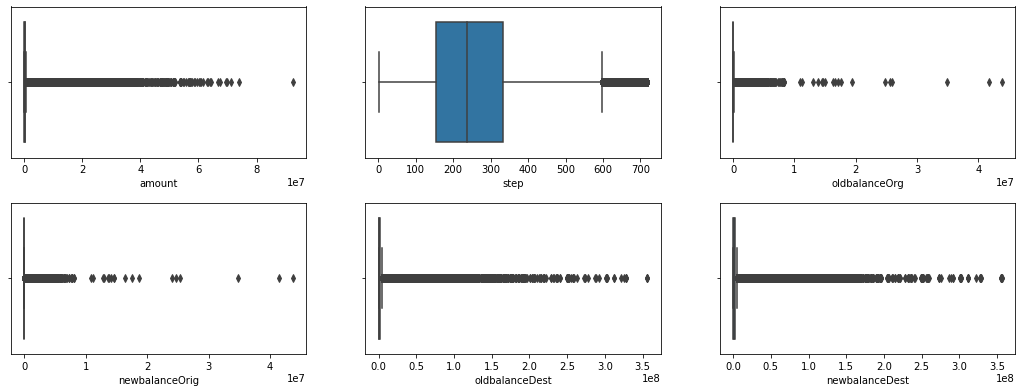

In [8]:
# Investigando Outliers
explorer = mtb.EDA(train_neg)
explorer.multi_boxplots(['amount', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [9]:
# Eliminando os Outliers - Pandas

# Passada 1
for var in ['amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    treino = drop_outliers(var, train_neg)

# Passada 2
for var in ['amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    treino1 = drop_outliers(var, treino)

treino1.shape

(2346304, 10)

In [10]:
# Eliminando os Outliers - Vaex

# Separando as observações com classe positiva
train_pos_vaex = train_vaex[train_vaex['isFraud']==1]
train_neg_vaex = train_vaex[train_vaex['isFraud']==0]

# Passada 1
for var in ['amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    treino_vaex = drop_outliers_vaex(var, train_neg_vaex)

# Passada 2 
for var in ['amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:  
    treino_vaex1 = drop_outliers_vaex(var, treino_vaex)

treino_vaex1.shape

(2346304, 10)

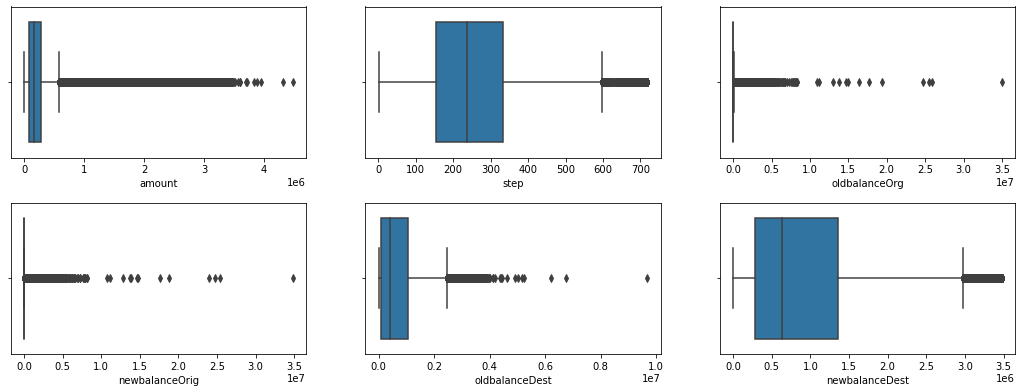

In [11]:
explorer1 = mtb.EDA(treino1)
explorer1.multi_boxplots(['amount', 'step','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [12]:
# Unindo classe negativa e positiva - Vaex
dataset = vaex.concat([train_pos_vaex, treino_vaex1])

# Unindo classe negativa e positiva - Pandas
dataset_pd = pd.concat([train_pos, treino1], axis=0)

# Feature Engineering

- Criar a variável type_dest a partir da primeira letra da variável nameDest. C representa 'Customer' e M representa 'Merchant'.

- Criar a variável erro_transaction, espera-se que 'amount' - (oldbalanceOrg - newbalanceOrig) seja igual a zero talvez erros maiores podem levar o modelo entender o evento de Fraude. 

- Criar variável por iteração 'amount' / 'step' = 'amount_step', o relacionamento do valor da transação por unidade de tempo pode nos ajudar a modelar o evento.

- Criar variáveis a partir do WeightOfEvidenceEncoder. WOE é uma medida do quão bem a observação suporta ou mitiga a hipostese - H0.
  - A partir dest_type criar woe_encoded_dest_type
  - A partir type criar woe_encoded_type
  
- Criar variáveis a partir do grupamento de 'type', calculando-se a média e o desvio padrão das variáveis 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'. Objetivo aqui é gerar sinais que ajude o modelo a separar melhor o evento de fraude das transações comuns.

- Criar variáveis aplicando transformação logaritmica nas varáveis 'amount','step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'. A transformação logartmica foi escolhida por ser aproriada para lidar com skew das variáveis citadas anteriormente.

- Realizar o binning, utilizando a estrátegia de k-means, com o objetivo de agrupar as variáveis 'amount','step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest' em 5 grupos colocando os dados em uma mesma escala e a divisão em grupos irá auxiliar o modelo a aprender os eventos de fraude. 

In [13]:
# dest_type; 1 - Merchant e 0-Customer e Dropping 'nameOrig', 'nameDest'
dataset_pd['dest_type'] = dataset_pd['nameDest'].apply(lambda x: 1 if x[0] == 'M' else 0)

# error_transaction
dataset_pd['error_transaction'] = dataset_pd['amount'] - (dataset_pd['oldbalanceOrg'] - dataset_pd['newbalanceOrig'])

# amount/step
dataset_pd['amount_step'] = dataset_pd['amount']/dataset_pd['step']

# GroupBy('amount') over Type
group = dataset_pd.groupby('type').agg({'amount':['mean','std']}).reset_index()
dataset_pd = dataset_pd.merge(group, left_on='type', right_on='type')


# GroupBy('oldbalanceOrg') over Type
group1 = dataset_pd.groupby('type').agg({'oldbalanceOrg':['mean','std']}).reset_index()
dataset_pd = dataset_pd.merge(group1, left_on='type', right_on='type')

# GroupBy('newbalanceOrig') over Type
group2 = dataset_pd.groupby('type').agg({'newbalanceOrig':['mean','std']}).reset_index()
dataset_pd = dataset_pd.merge(group2, left_on='type', right_on='type')


# GroupBy('oldbalanceDest') over Type
group3 = dataset_pd.groupby('type').agg({'oldbalanceDest':['mean','std']}).reset_index()
dataset_pd = dataset_pd.merge(group3, left_on='type', right_on='type')


# GroupBy('newbalanceDest') over Type
group4 = dataset_pd.groupby('type').agg({'newbalanceDest':['mean','std']}).reset_index()
dataset_pd = dataset_pd.merge(group4, left_on='type', right_on='type')


# Binning 'amount'
dataset_pd['amount_bin_log'] = np.floor(np.log10(dataset_pd['amount']))
dataset_pd['amount_bin_log'] = dataset_pd['amount_bin_log'].apply(lambda x: 0 if x == -np.inf else x)
dataset_pd['amount_kbins_kmeans'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans').fit_transform(np.array(dataset_pd['amount']).reshape(-1,1))

# Binning 'step'
dataset_pd['step_bin_log'] = np.floor(np.log10(dataset_pd['step']))
dataset_pd['step_bin_log'] = dataset_pd['step_bin_log'].apply(lambda x: 0 if x == -np.inf else x)
dataset_pd['step_kbins_kmeans'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans').fit_transform(np.array(dataset_pd['step']).reshape(-1,1))

# Binning 'oldbalanceOrg'
dataset_pd['oldbalanceOrg_bin_log'] = np.floor(np.log10(dataset_pd['oldbalanceOrg']))
dataset_pd['oldbalanceOrg_bin_log'] = dataset_pd['oldbalanceOrg_bin_log'].apply(lambda x: 0 if x == -np.inf else x)
dataset_pd['oldbalanceOrg_kbins_kmeans'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans').fit_transform(np.array(dataset_pd['oldbalanceOrg']).reshape(-1,1))

# Binning 'newbalanceOrig'
dataset_pd['newbalanceOrig_bin_log'] = np.floor(np.log10(dataset_pd['newbalanceOrig']))
dataset_pd['newbalanceOrig_bin_log'] = dataset_pd['newbalanceOrig_bin_log'].apply(lambda x: 0 if x == -np.inf else x)
dataset_pd['newbalanceOrig_kbins_kmeans'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans').fit_transform(np.array(dataset_pd['newbalanceOrig']).reshape(-1,1))

# Binning 'oldbalanceDest'
dataset_pd['oldbalanceDest_bin_log'] = np.floor(np.log10(dataset_pd['oldbalanceDest']))
dataset_pd['oldbalanceDest_bin_log'] = dataset_pd['oldbalanceDest_bin_log'].apply(lambda x: 0 if x == -np.inf else x)
dataset_pd['oldbalanceDest_kbins_kmeans'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans').fit_transform(np.array(dataset_pd['oldbalanceDest']).reshape(-1,1))

# Binning 'newbalanceDest'
dataset_pd['newbalanceDest_bin_log'] = np.floor(np.log10(dataset_pd['newbalanceDest']))
dataset_pd['newbalanceDest_bin_log'] = dataset_pd['newbalanceDest_bin_log'].apply(lambda x: 0 if x == -np.inf else x)
dataset_pd['newbalanceDest_kbins_kmeans'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans').fit_transform(np.array(dataset_pd['newbalanceDest']).reshape(-1,1))

# Droping nameOrig e nameDest
dataset_pd.drop(['nameOrig','nameDest'], inplace=True, axis=1)


# Encoding 'Type'
dataset_pd['type'] = dataset_pd['type'].apply(lambda x: 1 if x == 'TRANSFER' else 0)

# convertendo para vaex dataframe
dataset = vaex.from_pandas(df=dataset_pd)

# Woe
# dest_type
dataset = vaex.ml.WeightOfEvidenceEncoder(target='isFraud', features = ['dest_type']).fit_transform(dataset)

# Type
dataset = vaex.ml.WeightOfEvidenceEncoder(target='isFraud', features = ['type']).fit_transform(dataset)

In [14]:
# salvando os dados - CHECKPOINT
dataset.export_hdf5('../data/dataset_v1.hdf5')

# EDA

##  Análise Univariada

 - A partir da análise dos histogramas podemos notar um alto skew, na fase de pré-processamento será testado algumas soluções.(RobustScaler, possivelmente)
 - Também podemos notar que as variáveis criadas via Binning com transformação de log possuem um shape mais proxima de uma distribuição Gaussiana.
 - Também encontramos um padrão interessante, parece haver um acumulo de casos de Fraude em transações de maior montante financeiro. Tanto com relação a variável 'amount' quanto as variáveis de Old e New balances.
 - A partir da análise Multivariada, correlação de pearson (Númericas x Númericas) observamos que oldbalanceOrg e newbalanceOrg são altamente correlacionadas, assim como, oldbalanceDest e newbalanceDest, iremos eliminar uma variável balance de destino e uma de origem. A variável error_trasaction também esta apresentando grande correlação com a variável amount por isso iremos elimana-la também. A correlação entre as variáveis orignais e suas versões logaritimicas não passou de 0.70 manteremos elas para a etapa de Feature Selection. 
 - Ainda conforme análise Multivariada, correlação de cramer v (Categóricas x Categóricas) observamos que as variáveis oldbalanceOrg_kbins_kmeans, newbalanceOrig_kbins_kmeans, oldbalanceDest_kbins_kmeans possuiam alta correlação por essa razão seram eliminadas.

### Variáveis Numericas.

In [ ]:
#pip install ../dist/MyToolBox-0.0.1.tar.gz

In [ ]:
variables = ['amount',
           'error_transaction',
           'amount_step',
           'step',
           'oldbalanceOrg',
           'newbalanceOrig',
           'oldbalanceDest',
           'newbalanceDest',
           'amount_bin_log',
           'step_bin_log',
           'oldbalanceOrg_bin_log',
           'newbalanceOrig_bin_log',
           'oldbalanceDest_bin_log',
           'newbalanceDest_bin_log',
           'amount_kbins_kmeans',
           'step_kbins_kmeans',
           'oldbalanceOrg_kbins_kmeans',
           'newbalanceOrig_kbins_kmeans',
           'oldbalanceDest_kbins_kmeans',
           'newbalanceDest_kbins_kmeans'
           ]

n=1
plt.figure(figsize=(24, 16))
for column in dataset_pd[variables].columns:
    plt.subplot(5, 5, n)
    _ = sns.distplot(dataset_pd[column])
    n += 1
    
plt.subplots_adjust(hspace=0.3)

plt.show()

In [ ]:
# objeto temporario
all_data = dataset_pd.copy()

# amount
all_data['amount_bin'] = pd.qcut(all_data['amount'], q=10)

# step
all_data['step_bin'] = pd.qcut(all_data['step'], q=10)

# oldbalanceOrg'
all_data['oldbalanceOrg_bin'] = pd.qcut(all_data['oldbalanceOrg'], q=10, duplicates='drop')

# newbalanceOrig
all_data['newbalanceOrig_bin'] = pd.qcut(all_data['newbalanceOrig'], q=10, duplicates='drop')

obj_temp = all_data.loc[all_data['isFraud']==1, ]
obj_temp['counter'] = 1

### Faixas de Fraude 'amount_bin'.

In [ ]:
# Plot 'amount'
obj_temp.groupby('amount_bin').count()['counter'].plot(kind='bar')

In [ ]:
# Tabela com a quantidade de fraudes por faixa 'amount_bin'
obj_temp.groupby('amount_bin').count()['counter']

### Faixas de Fraude 'step_bin'.

In [ ]:
# Plot
obj_temp.groupby('step_bin').count()['counter'].plot(kind='bar')

In [ ]:
# Tabela com a quantidade de fraudes por faixa 'step_bin'
obj_temp.groupby('step_bin').count()['counter']

### Faixas de Fraude 'oldbalanceOrg_bin'.

In [ ]:
# Plot
obj_temp.groupby('oldbalanceOrg_bin').count()['counter'].plot(kind='bar')

In [ ]:
# Tabela com a quantidade de fraudes por faixa 'oldbalanceOrg_bin'
obj_temp.groupby('oldbalanceOrg_bin').count()['counter']

###  Faixas de Fraude 'newbalanceOrig_bin'.

In [ ]:
# Tabela com a quantidade de fraudes por faixa 'oldbalanceOrg_bin'
obj_temp.groupby('newbalanceOrig_bin').count()['counter'].plot(kind='bar')

In [ ]:
# Tabela com a quantidade de fraudes por faixa 'oldbalanceOrg_bin'
obj_temp.groupby('newbalanceOrig_bin').count()['counter']

## Análise Multivariada

###  Variáveis Númericas

In [ ]:
# Correlação de Pearson.
variaveis = ['amount',
             'error_transaction',
             'amount_step', 
             'step',
             'oldbalanceOrg',
             'newbalanceOrig',
             'oldbalanceDest',
             'newbalanceDest',
             'amount_bin_log',
             'step_bin_log',
             'oldbalanceOrg_bin_log',
             'oldbalanceDest_bin_log',
             'newbalanceOrig_bin_log',
             'newbalanceDest_bin_log']

Myheat_map(dataset=dataset_pd, variaveis=variaveis)

###  Variáveis Númericas - Eliminando as variáveis com alta correlação

In [ ]:
# Correlação de Pearson.
variaveis = ['amount',
             'amount_step', 
             'step',
             'oldbalanceOrg',
             'newbalanceDest',
             'amount_bin_log',
             'step_bin_log',
             'oldbalanceOrg_bin_log',
             'oldbalanceDest_bin_log',
             'newbalanceOrig_bin_log',
             'newbalanceDest_bin_log']

Myheat_map(dataset=dataset_pd, variaveis=variaveis)

###  Variáveis Númericas - Target

In [ ]:
from scipy.stats import pointbiserialr

# Variáveis númericas
num_vars =  ['amount',
             'error_transaction',
             'amount_step', 
             'step',
             'oldbalanceOrg',
             'newbalanceOrig',
             'oldbalanceDest',
             'newbalanceDest',
             'amount_bin_log',
             'step_bin_log',
             'oldbalanceOrg_bin_log',
             'oldbalanceDest_bin_log',
             'newbalanceOrig_bin_log',
             'newbalanceDest_bin_log']

# Correlações
corrs = [pointbiserialr(dataset_pd['isFraud'], dataset_pd[var])[0] for var in num_vars]
df_corr = pd.DataFrame({'isFraud': corrs}, index=num_vars)

# Plot Matrix
fig, ax = plt.subplots()
plt.subplot(1, 2, 1)
sns.heatmap(df_corr, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Pointbiserialr")

###  Variáveis Categóricas - Cramers v

In [ ]:
# Variáveis Categoricas
cols = [
        'type',
        'amount_kbins_kmeans',
        'step_kbins_kmeans',
        'oldbalanceOrg_kbins_kmeans',
        'newbalanceOrig_kbins_kmeans',
        'oldbalanceDest_kbins_kmeans',
        'newbalanceDest_kbins_kmeans',
        'isFraud'
        ]

# Sample pois nosso Dataset é muito grande
treino_sample = dataset_pd.sample(5000)

# alterando o tipo de dados para 'category'
for col in cols:
    treino_sample[col] = treino_sample[col].astype('category')

# Dicionario para registro das correlações
dict = {
        'type': [],
        'amount_kbins_kmeans': [],
        'step_kbins_kmeans': [],
        'oldbalanceOrg_kbins_kmeans': [],
        'newbalanceOrig_kbins_kmeans': [],
        'oldbalanceDest_kbins_kmeans': [],
        'newbalanceDest_kbins_kmeans': [],
        'isFraud': []
        }


for col in cols:
    for col1 in cols:
        corr = cramer_v(treino_sample[col], treino_sample[col1])
        dict[col].append(corr)

In [ ]:
# Matriz de Correlação
df_cramer = pd.DataFrame(dict)
df_cramer = df_cramer.set_index(df_cramer.columns)

In [ ]:
# HeatMap

fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 6)

mask = np.triu(np.ones_like(df_cramer, dtype=np.bool))
sns.heatmap(df_cramer, mask=mask, linewidths=.5, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Cramér V")

###  Variáveis Categóricas - Cramers v

In [ ]:
# Variáveis Categoricas, eliminando oldbalanceOrg_kbins_kmeans, newbalanceOrig_kbins_kmeans, oldbalanceDest_kbins_kmeans
cols = [
        'type',
        'amount_kbins_kmeans',
        'step_kbins_kmeans',
        'newbalanceDest_kbins_kmeans',
        'isFraud'
        ]

# Sample pois nosso Dataset é muito grande
treino_sample = dataset_pd.sample(5000)

# alterando o tipo de dados para 'category'
for col in cols:
    treino_sample[col] = treino_sample[col].astype('category')

# Dicionario para registro das correlações
dictt = {
        'type': [],
        'amount_kbins_kmeans': [],
        'step_kbins_kmeans': [],
        'newbalanceDest_kbins_kmeans': [],
        'isFraud': []
        }


for col in cols:
    for col1 in cols:
        corr = cramer_v(treino_sample[col], treino_sample[col1])
        dictt[col].append(corr)

# Matriz de Correlação
df_cramer1 = pd.DataFrame(dictt)
df_cramer1 = df_cramer1.set_index(df_cramer1.columns)

# HeatMap

fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 6)

mask = np.triu(np.ones_like(df_cramer1, dtype=np.bool))
sns.heatmap(df_cramer1, mask=mask, linewidths=.5, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Cramér V")

## Teste de Hiposteses

In [ ]:
from PIL import Image
Image.open("../img/map_mental.jpg")

Lista de Hipóteses!

1. O montante fraudado é maior para o 'type' transfer!
2. O percentual de error_transaction é maior que 50%!
3. O montante fraudado é maior com o 'dest_type' Customers que Merchant!
4. O oldbalanceOrig é sempre diferente de 0, já que se deve ter saldo para realizar uma transação!
5. A quantidade de transações fraudulentas é maior para o tipo de Origem 'Customer'!
6. A conta de uma transação fraudulenta 'TRANSFER' bate com a conta Origem de um CASH-OUT!
7. A quantidade de transações fraudulentas é maior na modalidade 'TRANSFER'!

###  H1 O montante fraudado é maior para o 'type' TRANSFER! [TRUE]

In [ ]:
dados_temp = dataset_pd.loc[dataset_pd['isFraud']==1, ]

AMOUNT_TRANSFER = dados_temp.loc[dados_temp['type']== 1, 'amount'].sum()
AMOUNT_CASH_OUT = dados_temp.loc[dados_temp['type']== 0, 'amount'].sum()

print(f'\n Montante de observações TRANSFER: {AMOUNT_TRANSFER}')
print(f'Montante de observações CASH_OUT: {AMOUNT_CASH_OUT}\n')

###  H2 O percentual de error_transaction é maior que 50%[TRUE]!

In [ ]:
# Erro
erro_acima_0 = dataset_pd.loc[dataset_pd['error_transaction'] != 0, ]

#Percentual do erro sobre dataset
perc_error = round(erro_acima_0.shape[0]/treino.shape[0]*100, 2)
print(f'O percentual de transações com erro são de {perc_error}')

###  H3 O montante fraudado é maior com o 'dest_type' Customers que Merchant![TRUE]

In [ ]:
dados_temp1 = dataset_pd.loc[dataset_pd['isFraud'] == 1, ['amount','dest_type']]

# Montantes
AMOUNT_CUSTOMER = round(dados_temp1.loc[dados_temp1['dest_type']==0, 'amount'].sum(),2)
AMOUNT_MERCHANT = round(dados_temp1.loc[dados_temp1['dest_type']==1, 'amount'].sum(),2)

# Report
print(f'Quantidade de observações Customers: {AMOUNT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {AMOUNT_MERCHANT}\n')

### H4 O oldbalanceOrig é sempre diferente de 0, já que se deve ter saldo para realizar uma transação![FALSE]

In [ ]:
# Percentual de operações amount != de zero oldBalanceOrig e newBalanceOrig são iguais a 0

quant_orig = dataset_pd.loc[(dataset_pd['amount'] != 0) & (dataset_pd['oldbalanceOrg'] == 0) & (dataset_pd['newbalanceOrig'] == 0), ]

perc_quant_orig = round(quant_orig.shape[0]/dataset_pd.shape[0], 2)*100
print(f'O percentual de casos onde o amount é diferente de 0 com oldbalanceDest e newbalanceDest iguais {perc_quant_orig}%')

###  H5 A quantidade de transações fraudulentas é maior para o tipo de Origem 'Customer'![TRUE]

In [ ]:
# cheando o tipo origem.
treino['nameOrig'].str[0].unique()

Obs: O tipo de origen 'Customer' é unico tipo de origem neste dataset!

In [ ]:
# Montantes
QUANT_CUSTOMER = dados_temp1.loc[dados_temp1['dest_type']==0, 'amount'].shape[0]
QUANT_MERCHANT = dados_temp1.loc[dados_temp1['dest_type']==1, 'amount'].shape[0]

# Report
print(f'Quantidade de observações Customers: {QUANT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {QUANT_MERCHANT}\n')

### H6 A conta de uma transação fraudulenta 'TRANSFER' bate com a conta Origem de um CASH-OUT![FALSE]

In [ ]:
CONTA_ORIG = treino1.loc[(treino1['isFraud']==1) & (treino1['type']=='TRANSFER'), 'nameDest']
CONTA_DEST = treino1.loc[(treino1['isFraud']==1) & (treino1['type']=='CASH_OUT'), 'nameOrig']

resultado = set(CONTA_ORIG).intersection(set(CONTA_DEST))
print(f'Contas encontradas:{len(resultado)}')

Nosso dataset não segue um padrão de fraude comum. de uma operação de 'TRANSFER' para uma conta fria seguida de um 'CASH_OUT'.

###  H7 A quantidade de transações fraudulentas é maior na modalidade 'TRANSFER'!

In [ ]:
# Montantes
QUANT_TRANSFER = dataset_pd.loc[(dataset_pd['isFraud']==1) & (dataset_pd['type']==1), 'amount'].shape[0]
QUANT_MERCHANT = dataset_pd.loc[(dataset_pd['isFraud']==1) & (dataset_pd['type']==0), 'amount'].shape[0]

# Report
print(f'Quantidade de observações Customers: {QUANT_CUSTOMER}')
print(f'Quantidade de observações Merchant: {QUANT_MERCHANT}\n')

#  Feature Selection

In [ ]:
from BorutaShap import BorutaShap
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler 

# Variaveis que não foram elimiandas durante anlise multivariada
variaveis = dataset.column_names[0:33]
dataset_pd.columns = dataset.column_names[0:33]

# Scaler
scaler = RobustScaler()

# Data
y = dataset_pd['isFraud']
X = dataset_pd[variaveis].drop('isFraud', axis=1)

# Xgboost
model = XGBClassifier()

# Selecionador de Features
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=False, )

Feature_Selector.fit(X=X,y=y, n_trials=10, random_state=0)

In [ ]:
subset = Feature_Selector.Subset()
subset.head()

# Data Preparation - Pipelines

- Pipeline 1 - StandardScaler() nas variáveis numericas sem considerar feature selection.
- Pipeline 2 - StandardScaler() nas variáveis numericas somente com as variáveis selecionadas

## Pipeline-1 - SGDC com Log loss

In [16]:
vaex.multithreading.thread_count_default = 16
features = ['step', 
            'amount', 
            'oldbalanceOrg',
            'newbalanceOrig',
            'oldbalanceDest',
            'newbalanceDest', 
            'error_transaction',
            'amount_step',
            'amountmean',
            'amountstd',
            'oldbalanceOrgmean',
            'oldbalanceOrgstd',
            'newbalanceOrigmean',
            'newbalanceOrigstd',
            'oldbalanceDestmean',
            'oldbalanceDeststd',
            'newbalanceDestmean',
            'newbalanceDeststd',
            'amount_bin_log',
            'step_bin_log',
            'oldbalanceOrg_bin_log',
            'newbalanceOrig_bin_log',
            'oldbalanceDest_bin_log',
            'newbalanceDest_bin_log',
            'woe_encoded_dest_type',
            'woe_encoded_type']

# Scaler
scaler = vaex.ml.StandardScaler(features=features, prefix='scaled_')
scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

features_train = dataset_scaled.get_column_names(regex='scaled*') + \
                 dataset_scaled.get_column_names(regex='.*_kmeans')+ \
                 ['type']

model = SGDClassifier(loss='log', 
                      eta0=0.001, 
                      learning_rate='constant',
                      random_state=42)


vaex_model_log = IncrementalPredictor(features=features_train, 
                                  target='isFraud', 
                                  model=model,
                                  batch_size=1_000_00,
                                  partial_fit_kwargs={'classes':[0,1]},
                                  num_epochs=1,
                                  shuffle=False,
                                  prediction_name='prediction')

vaex_model_log.fit(df=dataset_scaled, progress='widget')
df_log = vaex_model_log.transform(dataset_scaled)
df_log

#,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,dest_type,error_transaction,amount_step,"('amount', 'mean')","('amount', 'std')","('oldbalanceOrg', 'mean')","('oldbalanceOrg', 'std')","('newbalanceOrig', 'mean')","('newbalanceOrig', 'std')","('oldbalanceDest', 'mean')","('oldbalanceDest', 'std')","('newbalanceDest', 'mean')","('newbalanceDest', 'std')",amount_bin_log,amount_kbins_kmeans,step_bin_log,step_kbins_kmeans,oldbalanceOrg_bin_log,oldbalanceOrg_kbins_kmeans,newbalanceOrig_bin_log,newbalanceOrig_kbins_kmeans,oldbalanceDest_bin_log,oldbalanceDest_kbins_kmeans,newbalanceDest_bin_log,newbalanceDest_kbins_kmeans,woe_encoded_dest_type,woe_encoded_type,scaled_step,scaled_amount,scaled_oldbalanceOrg,scaled_newbalanceOrig,scaled_oldbalanceDest,scaled_newbalanceDest,scaled_error_transaction,scaled_amount_step,scaled_amountmean,scaled_amountstd,scaled_oldbalanceOrgmean,scaled_oldbalanceOrgstd,scaled_newbalanceOrigmean,scaled_newbalanceOrigstd,scaled_oldbalanceDestmean,scaled_oldbalanceDeststd,scaled_newbalanceDestmean,scaled_newbalanceDeststd,scaled_amount_bin_log,scaled_step_bin_log,scaled_oldbalanceOrg_bin_log,scaled_newbalanceOrig_bin_log,scaled_oldbalanceDest_bin_log,scaled_newbalanceDest_bin_log,scaled_woe_encoded_dest_type,scaled_woe_encoded_type,prediction
0,1,1,181.0,181.0,0.0,0.0,0.0,1,0,0.0,181.0,537361.7272602181,561751.6977020104,62861.969999974215,510485.68466055463,12877.763452953923,305816.9563440003,782646.8259206628,782540.1382098091,1313369.281028787,916688.4417441946,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.654878338327999,-4.536146803906333,-1.693131465331818,-0.748668584038229,-0.18809554590853814,-0.10993715591632539,-0.8618504253838751,-1.0683403859418812,-0.7562922512721365,-0.2646232806070302,2.256620322241861,2.256620322487125,2.2566203249116517,2.256620322393132,-2.2566203205112543,2.256620322285348,2.256620318761071,-2.2566196366385256,2.2566203215160923,2.2566203648601277,-4.551984515583558,-4.476938763986024,-0.07972519386963377,-0.33838015155983997,-2.1420056488892234,-6.985028621176604,-2.8438177084730815e-06,2.2566203271413205,1
1,1,1,2806.0,2806.0,0.0,0.0,0.0,1,0,0.0,2806.0,537361.7272602181,561751.6977020104,62861.969999974215,510485.68466055463,12877.763452953923,305816.9563440003,782646.8259206628,782540.1382098091,1313369.281028787,916688.4417441946,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.654878338327999,-4.536146803906333,-1.693131465331818,-0.7402279256542569,-0.1781678056820929,-0.10993715591632539,-0.8618504253838751,-1.0683403859418812,-0.7562922512721365,-0.010362044999741823,2.256620322241861,2.256620322487125,2.2566203249116517,2.256620322393132,-2.2566203205112543,2.256620322285348,2.256620318761071,-2.2566196366385256,2.2566203215160923,2.2566203648601277,-2.8473712974974856,-4.476938763986024,0.4100746592129692,-0.33838015155983997,-2.1420056488892234,-6.985028621176604,-2.8438177084730815e-06,2.2566203271413205,1
2,1,1,20128.0,20128.0,0.0,0.0,0.0,1,0,0.0,20128.0,537361.7272602181,561751.6977020104,62861.969999974215,510485.68466055463,12877.763452953923,305816.9563440003,782646.8259206628,782540.1382098091,1313369.281028787,916688.4417441946,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.654878338327999,-4.536146803906333,-1.693131465331818,-0.6845292267867656,-0.11265606617638463,-0.10993715591632539,-0.8618504253838751,-1.0683403859418812,-0.7562922512721365,1.6674715257390962,2.256620322241861,2.256620322487125,2.2566203249116517,2.256620322393132,-2.2566203205112543,2.256620322285348,2.256620318761071,-2.2566196366385256,2.2566203215160923,2.2566203648601277,-1.1427580794114136,-4.476938763986024,0.8998745122955721,-0.33838015155983997,-2.1420056488892234,-6.985028621176604,-2.8438177084730815e-06,2.2566203271413205,1
3,1,1,1277212.77,1277212.77,0.0,0.0,0.0,1,0,0.0,1277212.77,537361.7272602181,561751.6977020104,62861.969999974215,510485.68466055463,12877.763452953923,305816.9563440003,782646.8259206628,782540.13820

## Pipeline-1 - SGDC com Perceptron loss

In [ ]:
vaex.multithreading.thread_count_default = 16
features = ['step', 
            'amount', 
            'oldbalanceOrg',
            'newbalanceOrig',
            'oldbalanceDest',
            'newbalanceDest', 
            'error_transaction',
            'amount_step',
            'amountmean',
            'amountstd',
            'oldbalanceOrgmean',
            'oldbalanceOrgstd',
            'newbalanceOrigmean',
            'newbalanceOrigstd',
            'oldbalanceDestmean',
            'oldbalanceDeststd',
            'newbalanceDestmean',
            'newbalanceDeststd',
            'amount_bin_log',
            'step_bin_log',
            'oldbalanceOrg_bin_log',
            'newbalanceOrig_bin_log',
            'oldbalanceDest_bin_log',
            'newbalanceDest_bin_log',
            'woe_encoded_dest_type',
            'woe_encoded_type']

# Scaler
scaler = vaex.ml.StandardScaler(features=features, prefix='scaled_')
scaler.fit(dataset)
dataset_scaled = scaler.transform(dataset)

features_train = dataset_scaled.get_column_names(regex='scaled*') + \
                 dataset_scaled.get_column_names(regex='.*_kmeans')+ \
                 ['type']

model = SGDClassifier(loss='perceptron', eta0=0.001, learning_rate='constant',random_state=42)
vaex_model_perc = IncrementalPredictor(features=features_train, 
                                  target='isFraud', 
                                  model=model,
                                  batch_size=1_000_00,
                                  partial_fit_kwargs={'classes':[0,1]},
                                  num_epochs=1,
                                  shuffle=False,
                                  prediction_name='prediction')

vaex_model_perc.fit(df=dataset_scaled, progress='widget')
df_perc = vaex_model_perc.transform(dataset_scaled)
df_perc

## Pipeline-1 -  Xgboost

In [41]:
from vaex.ml.xgboost import XGBoostModel

# Spliting dados em treino e teste
dataset_scaled = dataset_scaled.sample(1000000)
df_train, df_test = dataset_scaled.ml.train_test_split(test_size=0.2, verbose=False)


# Features para treinamento
features_train = dataset_scaled.get_column_names(regex='scaled*') + \
                 dataset_scaled.get_column_names(regex='.*_kmeans')+ \
                 ['type']

# Grid de Parametros
params = {'learning_rate': 0.01,
          'max_depth': 5,
          'objective': 'binary:hinge',
          'eval_metric': 'auc',
          'subsample': 1,
          'random_state': 42,
          'n_jobs': -1}

# Intanciando e treinando o modelo
booster = XGBoostModel(features=features_train, 
                       target='isFraud', 
                       num_boost_round=500,
                       params=params)

booster.fit(df=df_train, 
            evals=[(df_train, 'train'),(df_test, 'test')], 
            early_stopping_rounds=5)

# Gerando as Previsões
dataset_test = booster.transform(df_test)
dataset_test

#,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,dest_type,error_transaction,amount_step,"('amount', 'mean')","('amount', 'std')","('oldbalanceOrg', 'mean')","('oldbalanceOrg', 'std')","('newbalanceOrig', 'mean')","('newbalanceOrig', 'std')","('oldbalanceDest', 'mean')","('oldbalanceDest', 'std')","('newbalanceDest', 'mean')","('newbalanceDest', 'std')",amount_bin_log,amount_kbins_kmeans,step_bin_log,step_kbins_kmeans,oldbalanceOrg_bin_log,oldbalanceOrg_kbins_kmeans,newbalanceOrig_bin_log,newbalanceOrig_kbins_kmeans,oldbalanceDest_bin_log,oldbalanceDest_kbins_kmeans,newbalanceDest_bin_log,newbalanceDest_kbins_kmeans,woe_encoded_dest_type,woe_encoded_type,scaled_step,scaled_amount,scaled_oldbalanceOrg,scaled_newbalanceOrig,scaled_oldbalanceDest,scaled_newbalanceDest,scaled_error_transaction,scaled_amount_step,scaled_amountmean,scaled_amountstd,scaled_oldbalanceOrgmean,scaled_oldbalanceOrgstd,scaled_newbalanceOrigmean,scaled_newbalanceOrigstd,scaled_oldbalanceDestmean,scaled_oldbalanceDeststd,scaled_newbalanceDestmean,scaled_newbalanceDeststd,scaled_amount_bin_log,scaled_step_bin_log,scaled_oldbalanceOrg_bin_log,scaled_newbalanceOrig_bin_log,scaled_oldbalanceDest_bin_log,scaled_newbalanceDest_bin_log,scaled_woe_encoded_dest_type,scaled_woe_encoded_type,xgboost_prediction
0,161,0,132971.28,0.0,0.0,984543.31,1072685.96,0,0,132971.28,825.9085714285715,173246.90923650007,178830.52590969772,47373.10882451304,180079.754135976,17850.253258152337,101746.4267326915,670584.6599667605,801405.9030142671,853199.2774894472,839256.3673847476,5.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,6.0,0.0,-5.654878338327999,-6.167820519576324,-0.5639672015844225,-0.32168291158413315,-0.18878008723462825,-0.10993715591632539,0.3697249051837079,0.16559348034167662,-0.25379705989399337,-0.20215651861649317,-0.44314056295444026,-0.4431405630139231,-0.44314056359113185,-0.4431405630180837,0.44314056275265334,-0.4431405629082535,-0.4431405620203256,0.44314043134798337,-0.44314056269240204,-0.44314057181943345,0.5618551386746585,0.4376888355594318,-1.0593249000348397,-0.33838015155983997,0.33748114840925747,1.0207507512102942,-2.8438177084730815e-06,-0.4431405636901689,1.0
1,378,0,316518.22,5156.0,0.0,0.0,316518.22,0,0,311362.22,837.3497883597882,173246.90923650007,178830.52590969772,47373.10882451304,180079.754135976,17850.253258152337,101746.4267326915,670584.6599667605,801405.9030142671,853199.2774894472,839256.3673847476,5.0,1.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,-5.654878338327999,-6.167820519576324,0.9674618311229827,0.26851023811621816,-0.16928011443175145,-0.10993715591632539,-0.8618504253838751,-0.704242629918497,0.42033790771274715,-0.20104830606267138,-0.44314056295444026,-0.4431405630139231,-0.44314056359113185,-0.4431405630180837,0.44314056275265334,-0.4431405629082535,-0.4431405620203256,0.44314043134798337,-0.44314056269240204,-0.44314057181943345,0.5618551386746585,0.4376888355594318,0.4100746592129692,-0.33838015155983997,-2.1420056488892234,-0.31354581085418876,-2.8438177084730815e-06,-0.4431405636901689,1.0
2,281,0,44361.65,0.0,0.0,1375491.91,1419853.56,0,0,44361.65,157.87064056939502,173246.90923650007,178830.52590969772,47373.10882451304,180079.754135976,17850.253258152337,101746.4267326915,670584.6599667605,801405.9030142671,853199.2774894472,839256.3673847476,4.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,6.0,1.0,6.0,1.0,-5.654878338327999,-6.167820519576324,0.28290599622612417,-0.6066061940070532,-0.18878008723462825,-0.10993715591632539,0.8587665211182406,0.5649478812479622,-0.5886506687695073,-0.26686362327660385,-0.44314056295444026,-0.4431405630139231,-0.44314056359113185,-0.4431405630180837,0.44314056275265334,-0.4431405629082535,-0.4431405620203256,0.44314043134798337,-0.44314056269240204,-0.44314057181943345,-1.1427580794114136,0.4376888355594318,-1.0593249000348397,-0.33838015155983997,0.8333785078689536,1.0207507512102942,-2.8438177084730815e-06,-0.4431405636901689,1.0
3,250,0,380950.72,41070.0,0.0,638778.12

## Pipeline-1 - LightGBM

In [51]:
import vaex
import vaex.ml.lightgbm

# Grid de Parametros
params = {'learning_rate': 0.01,
          'max_depth': 5,
          'num_leaves': 15,
          'application': 'binary',
          'num_class': 1,
          'subsample': 0.80,
          'colsample_bytree': 0.80,
          'n_jobs': -1}

# Intanciando e treinando o modelo
booster_light = vaex.ml.lightgbm.LightGBMModel(features=features_train, 
                                               target='isFraud', 
                                               num_boost_round=500, 
                                               params=params)
booster_light.fit(df=df_train, 
            valid_sets=[df_test],
            early_stopping_rounds=10)

# Gerando as Previsões
dataset_test = booster_light.transform(df_test)
dataset_test

TypeError: 'NoneType' object is not iterable

## Pipelines-2 - SGDC com Log Loss

## Pipelines-2 - SGDC com Perceptron Loss

## Pipeline-2 -  Xgboost

In [ ]:
# Features - variáveis numericas escolhidas pelo BorutaShap.
# features = ['step',
#             'oldbalanceOrg', 
#             'newbalanceOrig_bin_log', 
#             'newbalanceDest',
#             'amount_step', 
#             'amount',
#             'oldbalanceDest_bin_log'
#             ]

# Modelagem Machine Learning / Avaliação dos Modelos